# Predicting Electricity Usage of a New House

> ### A capstone project for Springboard Data Science Intensive Workshop.
>**Monica Hickox** || *monica.hickox@gmail.com*

## Executive Summary

This report will attempt to create a model that can predict the yearly electricity consumption of a home in the U.S. using features that don't require historical or behavioral knowledge of a homebuyer. The model should be able to be used from a single "walkthrough" of any house. The report follows the Cross Indsutry Standard Process for Data Mining (CRISP) methodology.

## Table of Contents

## 1. Business Understanding

### 1.1 Business Objectives

Appraisals of homes rarely take into account the energy usage of a home (1) although it's an expenditure that can be anywhere from 1.5% to 7.2% of household income (2). Due to this sizable percentage of spending, approximating the electricity bill beforehand can also be valuable to a homebuyer's lender in assessing risk and preventing a homebuyer from surprsing expenditures.

***
1. https://www.washingtonpost.com/realestate/mortgage-lenders-could-soon-take-homes-energy-costs-into-account/2011/10/24/gIQAyxjPPM_story.html?utm_term=.b424e2eb4d32
2. https://www.nrdc.org/experts/khalil-shahyd/study-highlights-energy-burden-households-and-how-energy-efficiency-can-help

### 1.2 Situation Assessment

There are energy usage calculators available on the web, but most require historical information which may not be available upon purchasing a new home. Additionally, the calculators available rely on the linear methodology of calculating energy use per appliance. While this is usually considered a valid "ball-park" estimate, it may miss other influential features of a house that can be discovered through data mining.

Homes across the United States use a variety of different fuels including natural gas, oil, propane, and biofuel. However, according to the Residential Energy Consumption Survey (RECS) data, virtually all homes use electricity. Electricity on average accounts for 43% of a home's energy usage and about 65% of residential utility bill cost.

### 1.3 Data Mining Goals

While online calculators usualy give a valid "ball park" estimate, this project will strive to create a predictive model that only uses variables that can be determined from a simple "walkthrough" of any unfurnished house. This means that historical energy usage data or knowledge of an occupant's habits will not be considered.

> *Initialize necessary add on packages*

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%pylab inline 
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

Populating the interactive namespace from numpy and matplotlib


----Put all imports in the beginning

-----Add a heading to the top. General. Write an introduction. Name, contact, etc. Brag about Crisp

Add numbers to headings. make a table of contents. Write an exective summary, 1 or 2 paragraphs.

Add error prediction to model.

Executive summary -> Table of contents

------More markdown cells than comments.

------More bullet points. Be able to run through and see approach quickly.

Plot labels (general name and units 

Put numbers on figures

Brag about crisp and methodology adherence.

Modeling: Building Baseline title, separate subtitles

Don't use abbreviations in graphs. Or anywhere.

Data cleaning -> Break paragraph. Make headers of what you're doing with short description

Put worst model first. For relative residuals use percentages (histogram?)

Make a line, put in legend, of average

-------One hot encoding is not necessary with random forests:
    http://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest
    https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science
    

    ----------Do one hot encoding and then do dimensionality reduction

    -----------Or just defend number of features with processing power.
    
-----Add an intermediary model with all numerical features

Histogram of residuals and put vertical line of the average.

Put it in a table (mean errors, averages) summarizing between the three models and actual data. In discussion.

Put stuff in different lines ~80 characters. PEP 8 rules.

## 2. Data Understanding and Assessment

### 2.1 Data Collection

The data used for this project comes from the EIA's Residential Energy Consumption Survey (3). The data comes in a spreadsheet initially examined with Excel and is supplemented by an Excel workbook that acts as a codebook to interpret feature names in the data spreadsheet (ex: the feature "DOLLAREL" is the dollar cost of electricity). Some responses in the data are integer numbers that correspond with categorical responses and these categorical responses are also decoded in the codebook. The EIA imputed values where none were returned at a residence.

3. https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

### 2.2 Data Description

A total of 12,083 residences were surveyed and each respondent was given a weighted value for how many homes in the US that single home represents. There are initially 931 features, many of which are obviously highly correlated (ex: electricity usage in KWH as one feature and electrcity usage in BTU as another feature) and others which flag features that were imputed and will not be features important to the calculator.

## 3. Data Preparation

### 3.1 Data Cleaning

This project will use two different files: the Residential Energy Consumption Survey (RECS) public codebook (denoted "pc" throughout the analysis) and the RECS data itself. First, the codebook is wrangled since it is more easily interpreted and will act as a filter for paring down the raw data. Since the goal of this calculator is to approximate electricity usage given only a simple walk-through of a new house, features that are inherently historical such as energy usage and cost are eliminated from the start.

> *The codebook requires minimal data cleaning. Some extra spaces in the 'Variable Name' column are stripped away and the Response Codes and Labels are turned into arrays instead of a single long text string that the raw file gives. Additionally, two features have text responses and the codebook is changed to reflect the categorical response in terms of integers rather than strings.*

In [2]:
# Load up public codebook
pc=pd.DataFrame.from_csv('cap-data/recs2009_public_codebook_simple.csv', index_col= None, encoding = 'utf-8')

# In the spirit of creating a calculator that doesn't require historical data, some variables inherently historical
# will be dropped.
pc=pc[pc['Response Labels'].str.contains('Dollars')==False]
pc=pc[pc['Variable Name'].str.contains('KWH')==False]
pc=pc[pc['Variable Name'].str.contains('BTU')==False]
pc=pc[pc['Variable Name'].str.contains('CUFEET')==False]
pc=pc[pc['Variable Description'].str.contains('flag')==False]
pc=pc[pc['Variable Description'].str.contains('used')==False]
pc=pc[pc['Variable Description'].str.contains('Supplier')==False]
pc=pc[pc['Variable Name'].str.contains('DOEID')==False]
pc=pc[pc['Variable Name'].str.contains('NWEIGHT')==False]

# Separate Response Codes and Response Labels and strip any spaces in Variable Names
pc['Response Codes']=[x.split('\r') if type(x)==str else x for x in pc['Response Codes']]
pc['Response Labels']=[x.split('\r') if type(x)==str else x for x in pc['Response Labels']]
pc['Variable Name']=pc['Variable Name'].str.strip()

# There are only two variables in the entire dataset that use text as a response. These will be changed manually.
pc['Response Codes'][13]=['1', '2']
pc['Response Codes'][12]=['1','2','3']

# The last few columns indicating fuel type will not be considered
pc = pc.drop(pc.columns[4:9], axis=1)

pc.head(2)

,Variable Name,Variable Description,Response Codes,Response Labels
1,REGIONC,Census Region,"[1, 2, 3, 4]","[Northeast Census Region, Midwest Census Regio..."
2,DIVISION,Census Division,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[New England Census Division (CT, MA, ME, NH, ..."


> *For the data, only two variables have a text response instead of numerical. The text responses are first numbered in the codebook and subsequently turned into integers that translate to a categorical response.*

In [3]:
# Load up data
data=pd.DataFrame.from_csv('cap-data/recs2009_public.csv', index_col = None, encoding = 'utf-8')
# Convert text response to numerical
data.UR=[(1 if x == 'U' else (2 if x == 'R' else x)) for x in data.UR]
data.METROMICRO=[(1 if x=='METRO' else (2 if x=='MICRO' else(3 if x=='NONE' else x))) for x in data.METROMICRO]

> *The following checks the data for nulls of which there are only 4 in the entire dataset. Returning to the original excel sheet, the two features that account for the missing data are reported as "not applicable" at a rate of 99%. Using this information, the missing data was filled in as the number -2 which translates to "not applicable" according to the public codebook.*

In [4]:
# Check for null entries and examine them
nan_rows=data[data.isnull().T.any().T]
nan_cols=data.columns[data.isnull().any()==True]
nan=nan_rows[nan_cols]

# Reviewing the original data, these variables will be set at -2 which represents "Not applicable." 99% of all other 
# responses returned with a -2. 
data=data.fillna(-2)

> *Finally, the target variable (variable name 'KWH') and the associated weights of each data point (variable name 'NWEIGHT') are extracted and the data features are filtered by the features left in the public codebook from previous examination.*

In [5]:
# Extract target variable (KWH) and Sample weights (NWEIGHT)
kwh=data.KWH
nwgt=data.NWEIGHT.as_matrix()

# Now remove variable columns deemed unnecessary from wrangling codebook
cdata=pd.DataFrame()
for varname in pc['Variable Name']:
    cdata[varname]=data[varname]

> *The tools used later currently do not incorporate weights to the analysis. Thus, the dataset will be expanded such that each data point is repeated as many times as it represents the US housing stock.*

In [6]:
# xdata=pd.DataFrame(columns=cdata.columns)
# mi=ceil(min(nwgt)/0.5) #Minimum factor of reduction for each data point to have at least one entry
# cap=sum(nwgt)/6000 #mi
# for i in cdata.index:
#     row=cdata[cdata.index==i]
#     ratio=nwgt[i]/sum(nwgt)
#     mult=int(round(cap*ratio))
#     #print(i)
#     #print(mult)
#     if mult>0:
#         xdata=xdata.append([row]*mult, ignore_index=True)
#         print(len(xdata))

In [7]:
udata=cdata

### 3.2 Data Exploration

> *The data is a mix of both categorical and continuum responses. The code below determines that there are 24 continuous-type responses and 217 categorical-type responses.*

In [8]:
cont=pc[pc['Response Codes'].isnull()==True] # Continuum responses in codebook
cat=pc[pc['Response Codes'].isnull()==False] # categorical responses in codebook

print('The number of continuous-type responses is %d' %len(cont))
print('The number of categorical-type responses is %d' %len(cat))

The number of continuous-type responses is 23
The number of categorical-type responses is 216


> *The target variable for this project is the electricity usage of a residence per year. This variable is denoted 'KWH' in the data and is extracted and examined below with descriptive statistics.*

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64


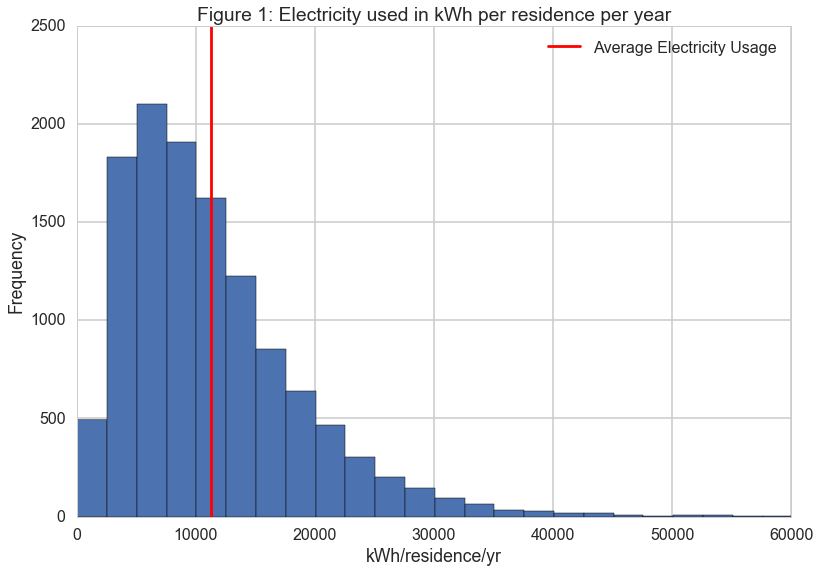

In [9]:
# Examine descriptive statistics
print(kwh.describe())

#Examine the kwh of data
plt.hist(kwh, bins=60)
plt.plot([kwh.mean(),kwh.mean()],[0,2500], color='red', label='Average Electricity Usage')
plt.title("Figure 1: Electricity used in kWh per residence per year")
plt.xlabel("kWh/residence/yr")
plt.ylabel("Frequency")
plt.xlim([0,60000])
plt.legend()
plt.show()

> *A common sense approach to approximating how much electricity a house consumes is to look at how big it is: the larger the house, the more energy it'll use. To explore this hypothesis, the following plots electricity usage per year versus squarefootage of a house.*

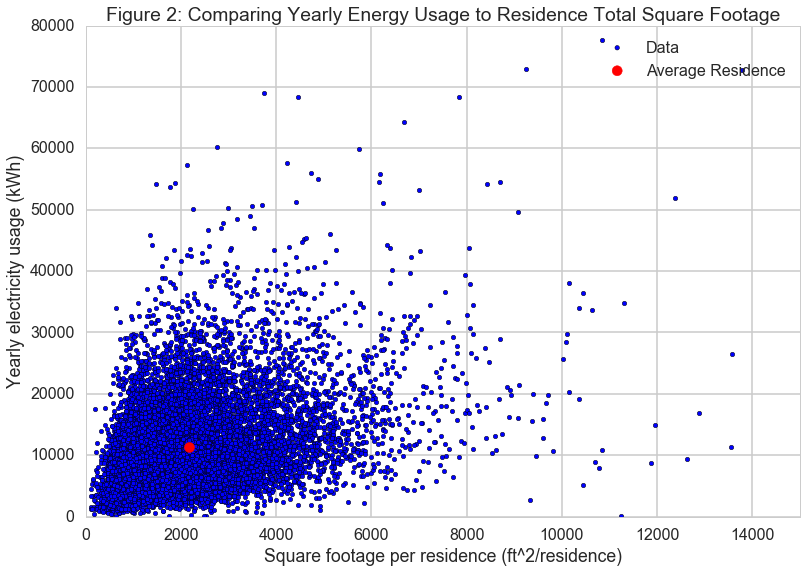

In [10]:
plt.scatter(udata.TOTSQFT, kwh, label='Data')
plt.scatter(udata.TOTSQFT.mean(),kwh.mean(), color='red', s=100, label='Average Residence')
plt.title("Figure 2: Comparing Yearly Energy Usage to Residence Total Square Footage")
plt.xlabel("Square footage per residence (ft^2/residence)")
plt.ylabel("Yearly electricity usage (kWh)")
plt.ylim([0,80000])
plt.xlim([0,15000])
plt.legend()
plt.show()

Examining figure 2 reveals that electricity usage becomes more variant as residence square footage increases. This implies that the end model will need to adjust error according to residence size. However, a linear trend will be assumed for the baseline model to which the more advanced model will be compared. 

# 4. Construction of a Predictive Model

### 4.1 Model Technique Selection

For this project, a random forest regressor is used as a supervised machine learning method. A random forest is an ensemble learning method that aggregates many decision trees and is used for classification and regression tasks. Sci-kit learn's RandomForestRegressor will be used for the main modeling technique.

The advantages of using RandomForestRegressor include:
- Unbiased handling of categorical predictors thereby avoiding the need for one-hot encoding*
    - The data contains many categorical variables labeled, for example, [1,2,3] however, some regressors would treat these as if the third entry '3' is more important than the first entry '1.'
- Fits highly non-linear interactions
- Relatively quick fit for large datasets
- Delivers a ranking of relative importance of features
    - An initial random forest regression will be the most effective way to determine which features to use while working with very limited processing power
- Robustness against overfitting

Sci-kit learn also has a built-in function called cross_val_predict that executes cross validation of the random forest model. The model will be cross-validated 10 times which is an arbitrary but frequently used number when performing cross validation.


*http://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest

### 4.2 Feature Selection
***
There is a total of 864 features in the original dataset. Due to limited processing power, an initial random forest regression will be executed on the whole dataset to order the features by importance.

While the definition of feature importance varies, Sci-kit learn defines "feature importance" by the total decrease in node impurity averaged over all the trees in the ensemble.

> *The following is an initial regressor with a sufficiently large amount of trees to accurately rank feature importance.*

In [11]:
n_est=100
forest=RandomForestRegressor(n_estimators=n_est)

In [12]:
forest.fit(udata, kwh, sample_weight=nwgt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]

> *A new dataframe is constructed that contains the features ordered from most important to least important.*

In [14]:
# Data frame with feature rankings
rfeats=pd.DataFrame(columns = ['no', 'imp', 'name'])

for f in range(udata.shape[1]):
    rfeats.loc[len(rfeats)]=[indices[f], importances[indices[f]], udata.columns[indices[f]]]

Generally, more features will mean a more informed and accurate model, however, the goal is to create an electricity calculator that only requires a few responses from new housing owners or renters. Functionally, this means the goal is to distill the model down to less than 20 features that will be translated into a questionnaire for new tenants.

> *To determine the optimal number of features, a cross-validated random forest regression model is performed 20 times where each successive model incorporates one more highly-ranked feature than the previous model. The features are incorporated in order of the dataframe "rfeats" which orders feature importances. The decrease in root mean square error with each successive model is shown in figure 3a.* 

> *To optimize the number of features for the intended questionnaire, the RMSE is stored for each successively more complex model. To determine when the RMSE has leveled off, the collective variance of the RMSEs up to that point is calculated and the maximum determines at which point the RMSE trend has leveled off. The results are shown in figure 3b.*

In [15]:
cv_method = KFold(n_splits = 10, shuffle = True, random_state = 0)
RMSE = pd.DataFrame(columns = ['rmse'])
VAR=pd.DataFrame(columns=['variance'])
b = 10 #maximum features in a regression analysis
a = linspace(1,b,b)
for i in a:
    top_feat = rfeats[:int(i)]
    X = udata.filter(items = top_feat.name)
    #predict=cross_val_predict(forest, X, kwh, cv=cv_method)
    
    
    cv = GridSearchCV(forest, param_grid={}, fit_params={'sample_weight': nwgt}, cv=cv_method)
    cv.fit(X,kwh)
    predict=cv.predict(X)
    
    # Examine RMSE for fitted data
    rmse = (mean_squared_error(kwh, predict, nwgt))**0.5
    RMSE.loc[len(RMSE)] = [rmse]
    
    # Calculate collective RMSE variance
    vari=RMSE.var()
    VAR.loc[len(VAR)]=vari[0]
    
    # Store current model results
    if len(VAR) > 2:
        if VAR.loc[len(VAR)-1][0] > VAR.loc[len(VAR)-2][0]:
            predict_f=predict
            rmse_f=rmse
            feat_num=int(i)

In [30]:
print('The optimal number of features is %i.' %feat_num)

The optimal number of features is 9.


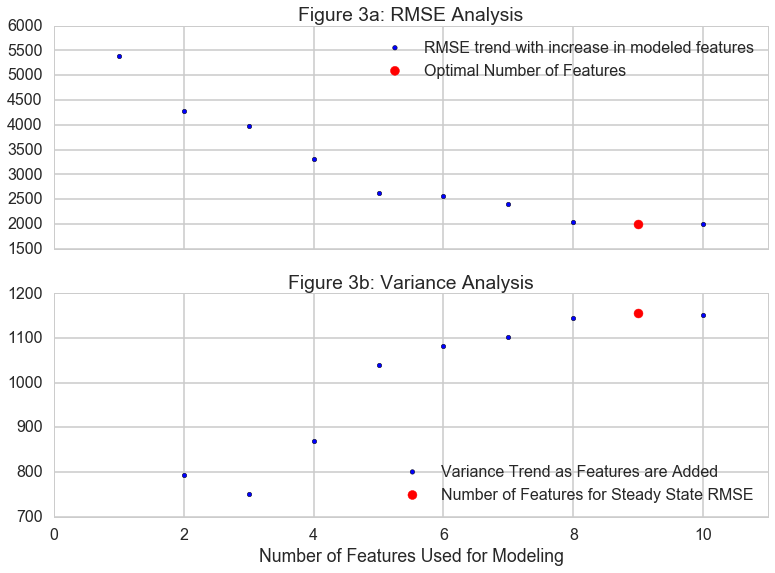

In [29]:
# Plot known values versus predicted values of linear regression and RF model
f, axarr=plt.subplots(2, sharex = True)

axarr[0].scatter(a, RMSE.rmse, label = 'RMSE trend with increase in modeled features')
axarr[0].scatter(feat_num,RMSE.rmse.loc[feat_num], color='red', s=80, label='Optimal Number of Features')
axarr[0].set_title('Figure 3a: RMSE Analysis')
axarr[0].legend(loc='upper right')
axarr[0].set_xlim([0,b+1])

axarr[1].scatter(a,(VAR.variance)**0.5, label='Variance Trend as Features are Added')
axarr[1].scatter(feat_num,(VAR.variance.max())**0.5, color='red', s=80,
                 label='Number of Features for Steady State RMSE')
axarr[1].set_title('Figure 3b: Variance Analysis')
axarr[1].legend(loc='lower right')
axarr[1].set_xlabel('Number of Features Used for Modeling')

## 5. Model Evaulation

### 5.1 Comparison of Random Forest Model to Simple Linear Models

To evaluate the random forest model, two simpler models are constructed to determine if the random forest model can outperform simpler approaches. The first and simplest model is a univariate linear regression using square footage to predict yearly electricity usage. The intermediary model is simply a multivariate linear model that uses all 23 non-categorical response features to predict yearly electricity usage.

> *The models are constructed below in the order of univariate linear, multivariate linear, and random forest model. Note that the cross validation random state is set and will thus have the same folds for cross validation across all models.*

In [18]:
# Build univariate linear model
lm = LinearRegression()
sqft=udata.TOTSQFT.reshape(len(udata.TOTSQFT), 1)
#kwh_predict_baseline=cross_val_predict(lm, sqft, kwh, cv=cv_method)

lin = GridSearchCV(lm, param_grid={}, fit_params={'sample_weight': nwgt}, cv=cv_method)
lin.fit(sqft,kwh)
kwh_predict_baseline=lin.predict(sqft)

# Examine RMSE for fitted data
rmse_baseline = (mean_squared_error(kwh, kwh_predict_baseline, nwgt))**0.5

In [19]:
# Build Intermediate (multivariate) linear model
contdata=pd.DataFrame()
for varname in cont['Variable Name']:
    contdata[varname]=data[varname]

#kwh_predict_intermed=cross_val_predict(lm, contdata, kwh, cv=cv_method)

lin.fit(contdata,kwh)
kwh_predict_intermed=lin.predict(contdata)

# Examine RMSE for fitted data
rmse_intermed = (mean_squared_error(kwh, kwh_predict_intermed, nwgt))**0.5

> *Now that the models are constructed, the results will be visually compared side-by-side on plots where the predicted results for each model is plotted against the measured results. The line y=x indicates perfect prediction.*

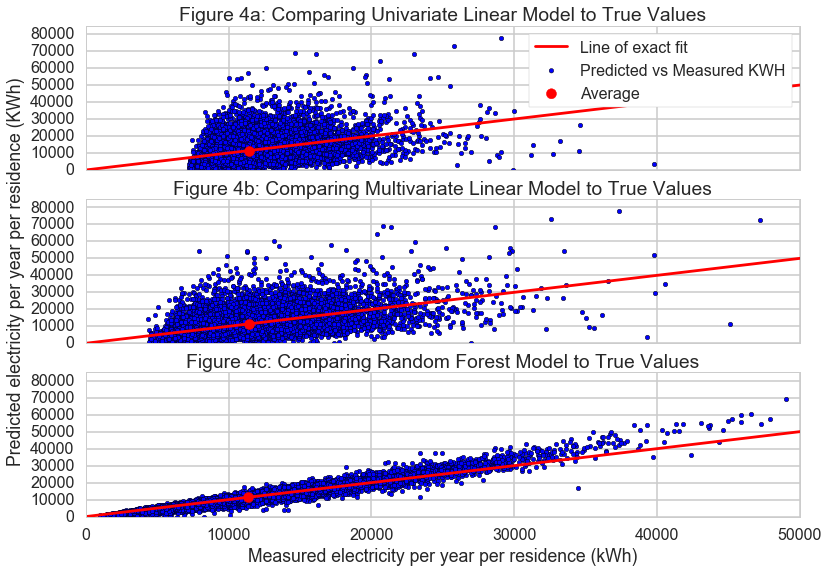

In [20]:
# Plot known values versus predicted values of linear regression and RF model
f, axarr=plt.subplots(3, sharex = True, sharey=True)
x_lim=[0, 50000]
y_lim=[0, 85000]

axarr[0].scatter(kwh_predict_baseline, kwh, label='Predicted vs Measured KWH')
axarr[0].scatter(average(kwh_predict_baseline),average(kwh), color='red', s=100, label='Average')
axarr[0].plot(y_lim, y_lim, color='red', label = 'Line of exact fit')
axarr[0].set_title('Figure 4a: Comparing Univariate Linear Model to True Values')
axarr[0].set_xlim(x_lim)
axarr[0].set_ylim(y_lim)
axarr[0].legend(loc='upper right', frameon = True)

axarr[1].scatter(kwh_predict_intermed, kwh, label = 'Multivariate Model Prediction vs Measured KWH')
axarr[1].scatter(average(kwh_predict_intermed),average(kwh), color='red', s=100, label='Average')
axarr[1].set_title('Figure 4b: Comparing Multivariate Linear Model to True Values')
axarr[1].plot(y_lim, y_lim, color='red', label = 'Line of exact fit')
axarr[1].set_ylabel('Predicted electricity per year per residence (KWh)')

axarr[2].scatter(predict_f, kwh, label = 'Random Forest Model Prediction vs Measured KWH')
axarr[2].scatter(average(predict_f),average(kwh), color='red', s=100, label='Average')
axarr[2].set_title('Figure 4c: Comparing Random Forest Model to True Values')
axarr[2].plot(y_lim, y_lim, color='red', label = 'Line of exact fit')
axarr[2].set_xlabel('Measured electricity per year per residence (kWh)')

> *Residuals are examined in figures 5 a-c below to see if any patterns emerge. Although the multivariate baseline model and the random forest model depend upon more variables than residence square footage, the results will be plotted against square footage for visual comparison with the univariate model.*

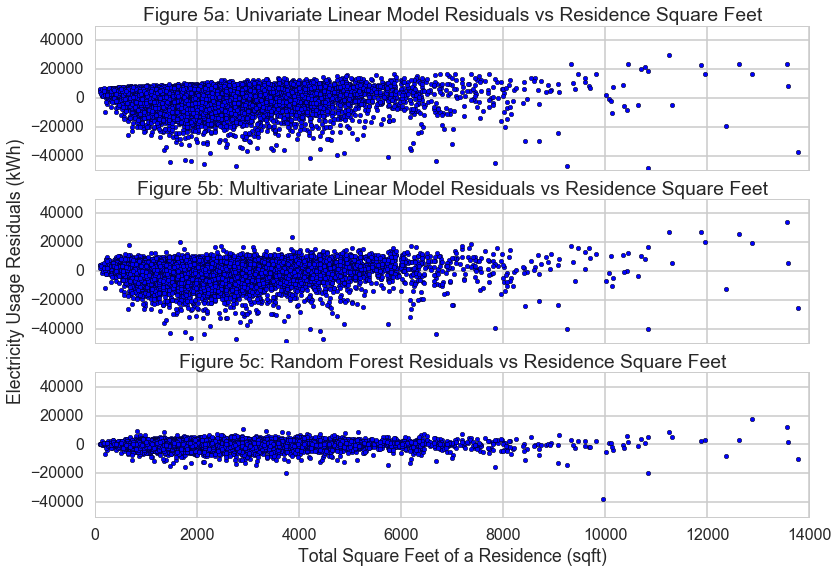

In [21]:
# Plot residuals of models
f, axarr = plt.subplots(3, sharex = True, sharey = True)

axarr[0].scatter(udata.TOTSQFT, kwh_predict_baseline-kwh)
axarr[0].set_title('Figure 5a: Univariate Linear Model Residuals vs Residence Square Feet')
axarr[0].set_xlim([0, 14000])
axarr[0].set_ylim([-50000, 50000])

axarr[1].scatter(udata.TOTSQFT, kwh_predict_intermed-kwh)
axarr[1].set_title('Figure 5b: Multivariate Linear Model Residuals vs Residence Square Feet')
axarr[1].set_ylabel('Electricity Usage Residuals (kWh)')

axarr[2].scatter(udata.TOTSQFT, predict_f-kwh)
axarr[2].set_title('Figure 5c: Random Forest Residuals vs Residence Square Feet')
axarr[2].set_xlabel('Total Square Feet of a Residence (sqft)')

> *Histograms of the residuals are produced below to better examine the spread of each model residuals.*

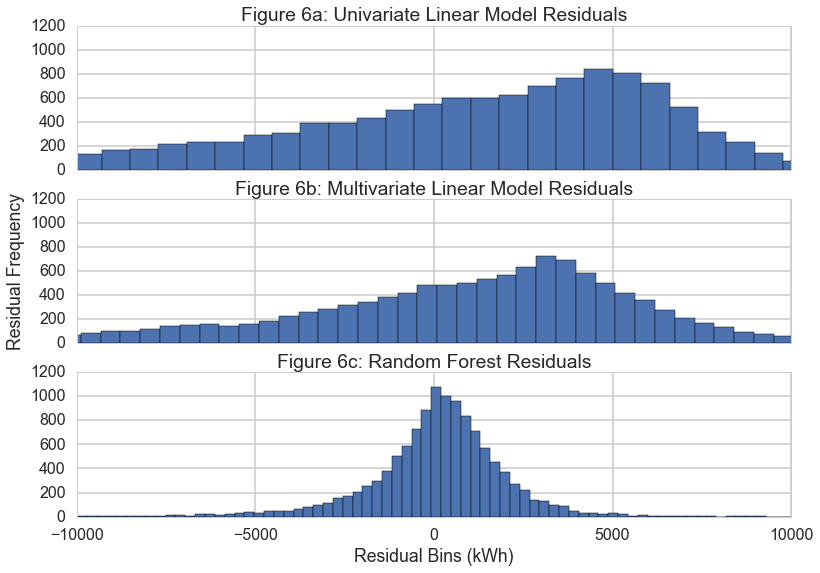

In [129]:
# Plot histogram of residuals of models
f, axarr = plt.subplots(3, sharex = True, sharey = True)

bins=200

axarr[0].hist(kwh_predict_baseline-kwh, bins=bins)
axarr[0].set_title('Figure 6a: Univariate Linear Model Residuals')
axarr[0].set_xlim([-10000, 10000])

axarr[1].hist(kwh_predict_intermed-kwh, bins=bins)
axarr[1].set_title('Figure 6b: Multivariate Linear Model Residuals')
axarr[1].set_ylabel('Residual Frequency')

axarr[2].hist(predict_f-kwh, bins=bins)
axarr[2].set_title('Figure 6c: Random Forest Residuals')
axarr[2].set_xlabel('Residual Bins (kWh)')

Figure 6 shows that the random forest model outperforms the linear models by producing less-skewed and tighter residual curve, but it is difficult to discern the extent of deviation. Figures 7 a-c below plot the residual relative to the reported electricity usage. That is, residual of a data entry divided by the reported electricity usage.

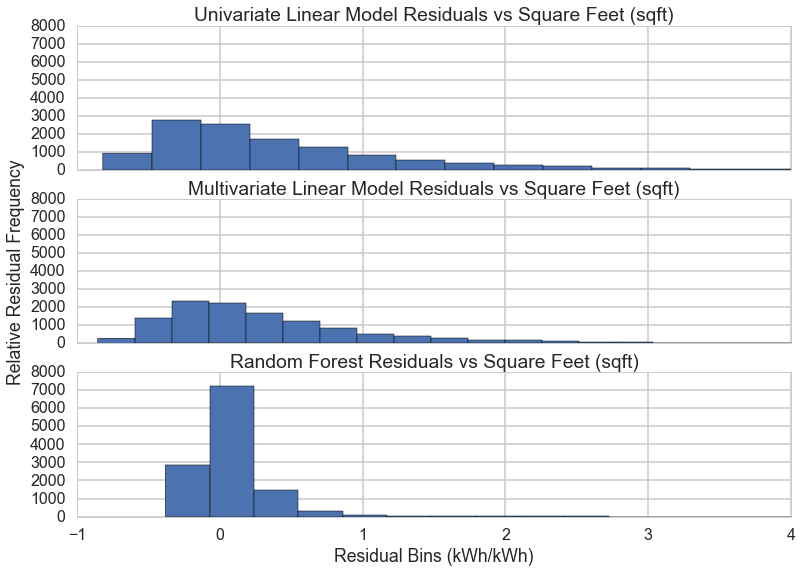

In [127]:
# Plot histogram of relative residuals of models
f, axarr = plt.subplots(3, sharex = True,sharey = True)

bins=100

relres1=pd.DataFrame((kwh_predict_baseline-kwh)/kwh)
plt1=relres1[abs(relres1.KWH)<50]
axarr[0].hist(plt1.KWH, bins=bins)
axarr[0].set_title('Univariate Linear Model Residuals vs Square Feet (sqft)')
axarr[0].set_xlim([-1,4])

relres2=pd.DataFrame((kwh_predict_intermed-kwh)/kwh)
plt2=relres2[abs(relres2.KWH)<50]
axarr[1].hist(plt2.KWH, bins=bins)
axarr[1].set_title('Multivariate Linear Model Residuals vs Square Feet (sqft)')
axarr[1].set_ylabel('Relative Residual Frequency')

relres3=pd.DataFrame((predict_f-kwh)/kwh)
plt3=relres3[abs(relres3.KWH)<50]
axarr[2].hist(plt3.KWH, bins=bins)
axarr[2].set_title('Random Forest Residuals vs Square Feet (sqft)')
axarr[2].set_xlabel('Residual Bins (kWh/kWh)')

# Error Bars

In [24]:
def pred_ints(model, X, percentile):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X.loc[x]))
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [27]:
err_down, err_up = pred_ints(forest, X_f, percentile=95)

## Discussion